<a href="https://colab.research.google.com/github/katia-kitaguti/uber-fare-prediction/blob/main/202406%7CUber_Ride_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Settings & Functions


In [1]:
# Access Kaggle
from google.colab import userdata
import os

# Deal with dataframes
import pandas as pd
import numpy as np

# Build graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Deal with dates
from datetime import datetime

#Deal with geographic data
from geopy.distance import geodesic

# Models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# Create Table
from tabulate import tabulate

#Print results
from pprint import pprint

In [2]:
!kaggle datasets download -d kushsheth/uber-ride-price-prediction

Dataset URL: https://www.kaggle.com/datasets/kushsheth/uber-ride-price-prediction
License(s): CC0-1.0
uber-ride-price-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
os.environ["My_Key"] = userdata.get('My_Key')
os.environ["User_Name"] = userdata.get('User_Name')

In [4]:
! unzip "uber-ride-price-prediction.zip"

Archive:  uber-ride-price-prediction.zip
replace uber.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [35]:
def print_table_results (results_table):

  cols_name = ["Model", "MSE", "R^2 Score"]

# Find the index of the row with the maximum R^2 Score value
  max_r2_index = max(range(len(results_table)), key=lambda i: results_table[i][2])

# Define ANSI escape codes for color formatting
  color_start = '\033[92m'  # Green color
  color_end = '\033[0m'  # Reset color

# Iterate through rows and print, coloring the row with the maximum R^2 Score value
  for i, row in enumerate(results_table):
      if i == max_r2_index:
          # Print the row with green color
          print(color_start + tabulate([row], headers=cols_name, tablefmt="fancy_grid") + color_end)
      else:
          # Print other rows without color
          print(tabulate([row], headers=cols_name, tablefmt="fancy_grid"))

In [9]:
def haversine(lat1, lon1, lat2, lon2):
  # Converting latitude and longitude from degrees
  lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

  #Haversine formula
  dlat = lat2 - lat1
  dlon = lon2 - lon1
  a = np.sin(dlat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2 ) ** 2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
  r = 6371 # Radius of the Earth in kilometers
  return c * r

df_rides['distance'] = haversine(df_rides['pickup_latitude'], df_rides['pickup_longitude'], df_rides['dropoff_latitude'], df_rides['dropoff_longitude'])

df_rides.head()
#Creating the new column

<ipython-input-9-41a27007a9e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides['distance'] = haversine(df_rides['pickup_latitude'], df_rides['pickup_longitude'], df_rides['dropoff_latitude'], df_rides['dropoff_longitude'])


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,24238194,52:06.0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323
1,27835199,04:56.0,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590
2,44984355,45:00.0,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377
3,25894730,22:21.0,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683
4,17610152,47:00.0,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450


# Base & Data Treatments

In [5]:
df_rides = pd.read_csv("uber.csv")
df_rides

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,52:06.0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,04:56.0,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,45:00.0,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,22:21.0,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,47:00.0,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,49:00.0,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,09:00.0,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,42:00.0,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,56:25.0,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695416,1


In [6]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


We can see that we have null values in dropoff_longitude and dropoff_latitude columns

In [7]:
df_rides = df_rides.dropna()
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         199999 non-null  int64  
 1   key                199999 non-null  object 
 2   fare_amount        199999 non-null  float64
 3   pickup_datetime    199999 non-null  object 
 4   pickup_longitude   199999 non-null  float64
 5   pickup_latitude    199999 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.3+ MB


In [8]:
df_rides['pickup_datetime'] = pd.to_datetime(df_rides['pickup_datetime'])

<ipython-input-8-9a5830633997>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides['pickup_datetime'] = pd.to_datetime(df_rides['pickup_datetime'])


# Exploratory Data Analysis (EDA)

In [10]:
df_rides.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,1.999990e+05,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,2.771248e+07,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543,20.855350
std,1.601386e+07,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995,382.964642
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,0.000000
25%,1.382534e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000,1.215222
50%,2.774524e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,2.120992
75%,4.155535e+07,12.500000,-73.967154,40.767158,-73.963659,40.768001,2.000000,3.875169
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,16409.239135


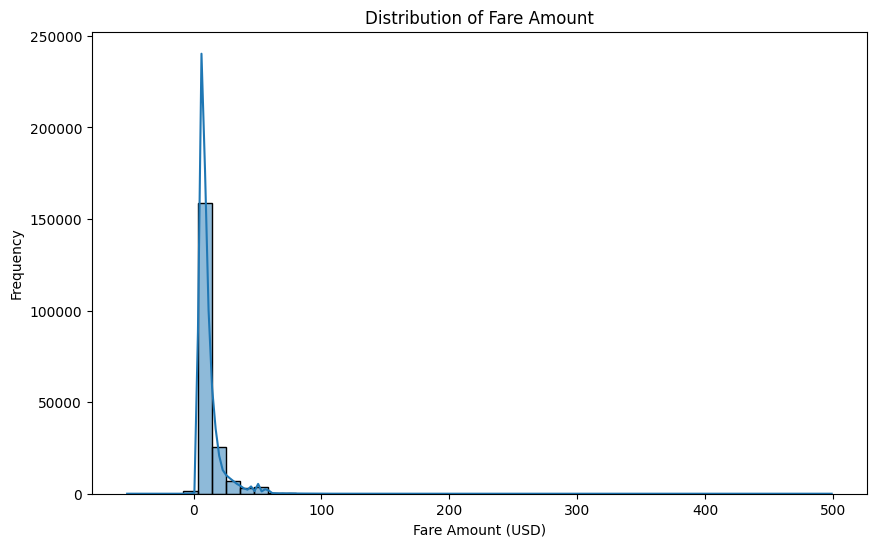

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(df_rides['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount (USD)')
plt.ylabel('Frequency')
plt.show()

- 75% of rides are less or equal than USD 12.5.

<ipython-input-12-1c0dfc0703e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides['pickup_date'] = df_rides['pickup_datetime'].dt.date


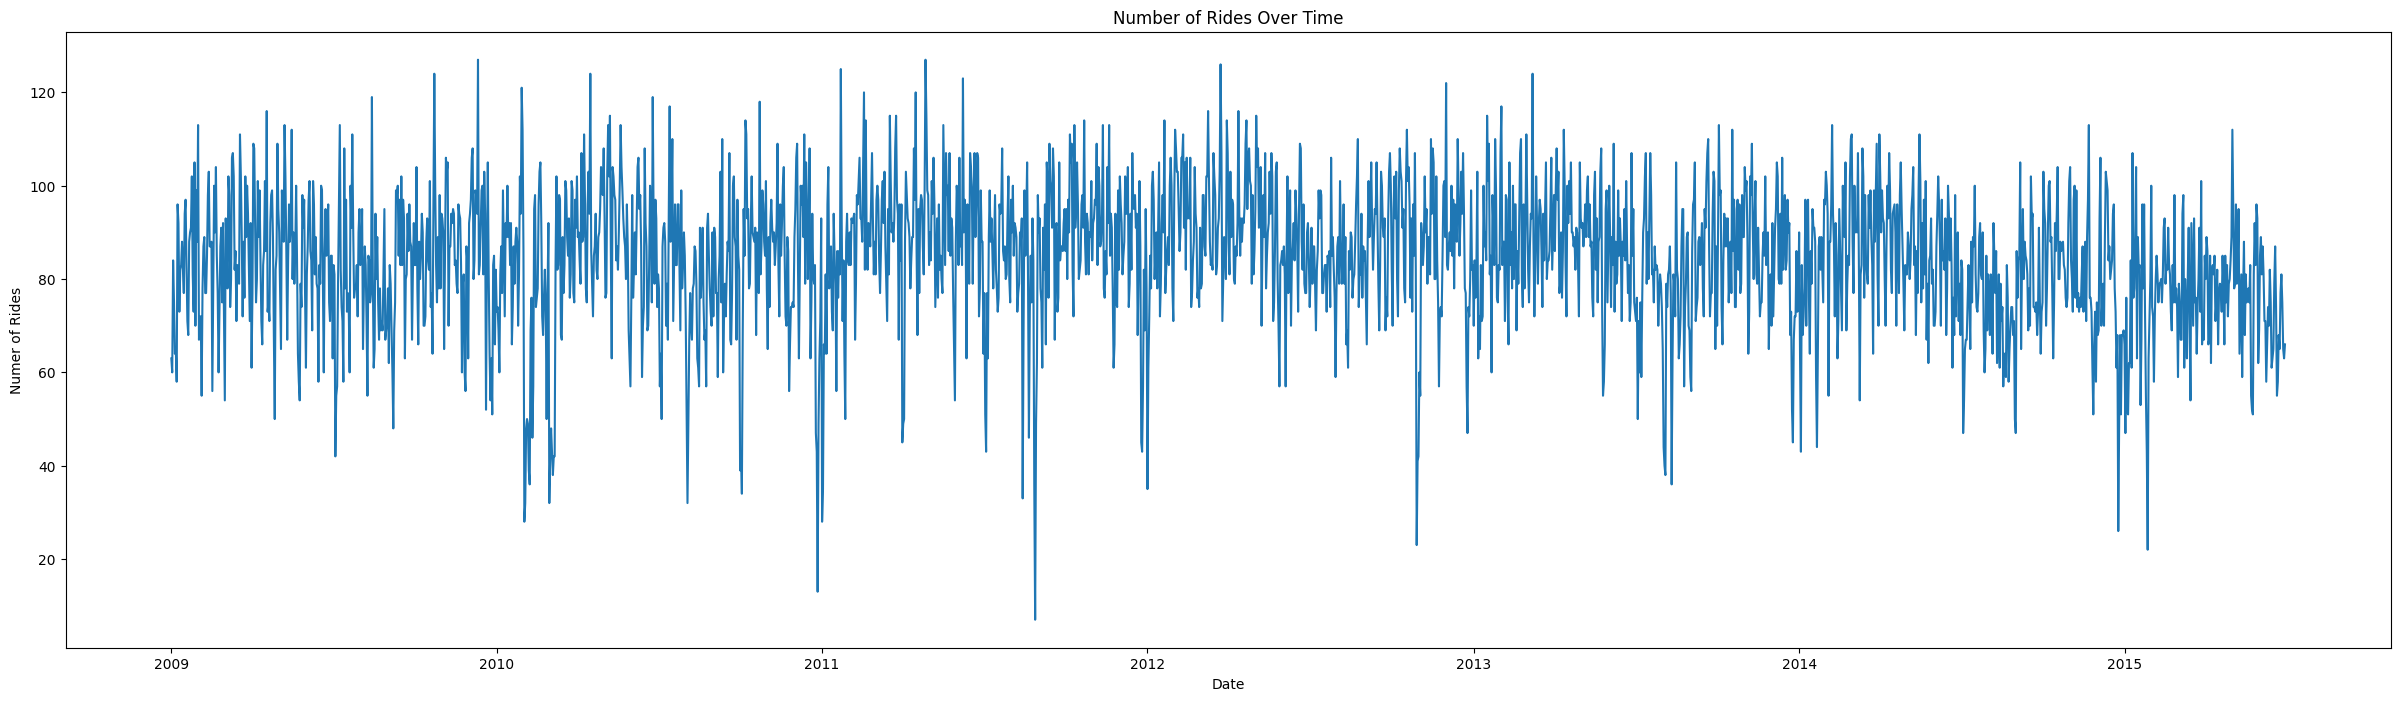

In [12]:
df_rides['pickup_date'] = df_rides['pickup_datetime'].dt.date
rides_per_day = df_rides.groupby('pickup_date').size()

plt.figure(figsize=(30,8))
rides_per_day.plot()
plt.title('Number of Rides Over Time')
plt.xlabel('Date')
plt.ylabel('Numer of Rides')
plt.show()


# Modeling

### Linear Regression:

In [13]:
# Definition of variables
X = df_rides[['distance', 'passenger_count']]
y = df_rides['fare_amount']

#Splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

#Using LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict using test
y_pred = model_lr.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

print(f'Linear Regression Metrics')
print(f'----------')
print(f'Mean Squared Error: {mse_lr}')
print(f'R^2 Score: {r2_lr}')

Linear Regression Metrics
----------
Mean Squared Error: 100.05093571721099
R^2 Score: 0.0006030233541932661


### Neural Network

In [14]:
model_nw = MLPRegressor(hidden_layer_sizes=(100,),max_iter=10000)
model_nw.fit(X_train, y_train)

MLPRegressor(max_iter=10000)

In [15]:
# Predict using test
y_pred = model_nw.predict(X_test)

# Evaluate the model
mse_nw = mean_squared_error(y_test, y_pred)
r2_nw = r2_score(y_test, y_pred)

print(f'Neural Network Metrics')
print(f'----------')
print(f'Mean Squared Error: {mse_nw}')
print(f'R^2 Score: {r2_nw}')


Neural Network Metrics
----------
Mean Squared Error: 30.48234242445673
R^2 Score: 0.695515482771804


### Random Forest

In [16]:
model_rf = RandomForestRegressor(n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [17]:
# Predict using test
y_pred = model_rf.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

print(f'Random Forest Metrics')
print(f'----------')
print(f'Mean Squared Error: {mse_rf}')
print(f'R^2 Score: {r2_rf}')

Random Forest Metrics
----------
Mean Squared Error: 37.90513588825094
R^2 Score: 0.6213700758067987


### Semi Final Results

In [36]:
results_data_semi_final = [["Linear Regression", mse_lr, r2_lr],
                    ["Neural Network", mse_nw, r2_nw],
                    ["Random Forest", mse_rf, r2_rf]]
print_table_results(results_data_semi_final)

╒═══════════════════╤═════════╤═════════════╕
│ Model             │     MSE │   R^2 Score │
╞═══════════════════╪═════════╪═════════════╡
│ Linear Regression │ 100.051 │ 0.000603023 │
╘═══════════════════╧═════════╧═════════════╛
╒════════════════╤═════════╤═════════════╕
│ Model          │     MSE │   R^2 Score │
╞════════════════╪═════════╪═════════════╡
│ Neural Network │ 30.4823 │    0.695515 │
╘════════════════╧═════════╧═════════════╛
╒═══════════════╤═════════╤═════════════╕
│ Model         │     MSE │   R^2 Score │
╞═══════════════╪═════════╪═════════════╡
│ Random Forest │ 37.9051 │     0.62137 │
╘═══════════════╧═════════╧═════════════╛


By looking at the results above, the best model for this situation is Neural Network.

### Tuning Hyper parameters of Neural Network

In [19]:
hidden_layer_sizes = [(100,)]
activations = ['relu','tanh','logistic']
learning_rates = ['constant','adaptive']
solvers = ['adam']

random_grid = {'hidden_layer_sizes': hidden_layer_sizes,
               'activation':activations,
               'learning_rate':learning_rates,
               'solver':solvers
}
pprint(random_grid)

{'activation': ['relu', 'tanh', 'logistic'],
 'hidden_layer_sizes': [(100,)],
 'learning_rate': ['constant', 'adaptive'],
 'solver': ['adam']}


In [21]:
model_hypertuning_results = []
for hidden_layer_size in hidden_layer_sizes:
  for activation in activations:
    for learning_rate in learning_rates:
      for solver in solvers:
        model_nw_hyper = MLPRegressor(hidden_layer_sizes=hidden_layer_size,
               activation=activation,
               learning_rate=learning_rate,
               solver=solver)
        model_nw_hyper.fit(X_train, y_train)
        y_pred_hyper = model_nw_hyper.predict(X_test)

          # Evaluate the model
        mse_nw_hyper = mean_squared_error(y_test, y_pred_hyper)
        r2_nw_hyper = r2_score(y_test, y_pred_hyper)

        model_hypertuning_results.append({'hidden_layer_sizes': hidden_layer_size,
               'activation':activation,
               'learning_rate':learning_rate,
               'solver':solver,
               'mse': mse_nw_hyper,
               'r2_score':r2_nw_hyper
              })

df_nw_hypertuning = pd.DataFrame(model_hypertuning_results)
df_nw_hypertuning


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,hidden_layer_sizes,activation,learning_rate,solver,mse,r2_score
0,"(100,)",relu,constant,adam,30.219883,0.698137
1,"(100,)",relu,adaptive,adam,38.070990,0.619713
2,"(100,)",tanh,constant,adam,29.199599,0.708329
3,"(100,)",tanh,adaptive,adam,29.135913,0.708965
4,"(100,)",logistic,constant,adam,29.428120,0.706046
5,"(100,)",logistic,adaptive,adam,29.502964,0.705298


You can test different kind of parameters, such as:

param_grid = {
          
          'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam']}

But due to the limitation of Colab, I ended up testing iterate 2 of them. Even though, it lasted 16 min to run the whole cell.

In [29]:
df_nw_hypertuning_ordered = df_nw_hypertuning.sort_values(by='r2_score', ascending=False).reset_index(drop=True)
df_nw_hypertuning_ordered

,hidden_layer_sizes,activation,learning_rate,solver,mse,r2_score
0,"(100,)",tanh,adaptive,adam,29.135913,0.708965
1,"(100,)",tanh,constant,adam,29.199599,0.708329
2,"(100,)",logistic,constant,adam,29.428120,0.706046
3,"(100,)",logistic,adaptive,adam,29.502964,0.705298
4,"(100,)",relu,constant,adam,30.219883,0.698137
5,"(100,)",relu,adaptive,adam,38.070990,0.619713


Considering the changes done, the best model is:

    'hidden_layer_sizes': [(100,)],
    'activation': ['tanh'],
    'learning_rate': ['adaptive'],
    'solver': ['adam']}

### Final Results

In [37]:
df_nw_hypertuning_ordered.at[0, 'r2_score']

0.7089648113256165

In [38]:
results_data = results_data_semi_final = [["Linear Regression", mse_lr, r2_lr],
                    ["Neural Network", mse_nw, r2_nw],
                    ["Random Forest", mse_rf, r2_rf],
                    ["Tuned Hyperparameters Neural Network",df_nw_hypertuning_ordered.at[0, 'mse'] ,df_nw_hypertuning_ordered.at[0, 'r2_score']]]
print_table_results(results_data)


╒═══════════════════╤═════════╤═════════════╕
│ Model             │     MSE │   R^2 Score │
╞═══════════════════╪═════════╪═════════════╡
│ Linear Regression │ 100.051 │ 0.000603023 │
╘═══════════════════╧═════════╧═════════════╛
╒════════════════╤═════════╤═════════════╕
│ Model          │     MSE │   R^2 Score │
╞════════════════╪═════════╪═════════════╡
│ Neural Network │ 30.4823 │    0.695515 │
╘════════════════╧═════════╧═════════════╛
╒═══════════════╤═════════╤═════════════╕
│ Model         │     MSE │   R^2 Score │
╞═══════════════╪═════════╪═════════════╡
│ Random Forest │ 37.9051 │     0.62137 │
╘═══════════════╧═════════╧═════════════╛
╒══════════════════════════════════════╤═════════╤═════════════╕
│ Model                                │     MSE │   R^2 Score │
╞══════════════════════════════════════╪═════════╪═════════════╡
│ Tuned Hyperparameters Neural Network │ 29.1359 │    0.708965 │
╘══════════════════════════════════════╧═════════╧═════════════╛


# References


https://www.kaggle.com/code/mohamedsaqibshouqi/uber-fare-prediction-analysis#Exploratory-Data-Analysis-(EDA)

https://www.kaggle.com/code/tikaramsubedy/uber-ride-fare-prediction-model

https://stackoverflow.com/questions/61163759/tuning-mlpregressor-hyper-parameters